# Was man mit relativ wenig schon machen kann: Semantische Beziehungen in den Bundestagsdebatten.

In diesem Beispiel für unsere erste Sitzung möchte ich die prinzipielle Idee vorstellen, wie man mit ein wenig Wissen, mit wenig Progarmmierkenntnissen schon einiges machen kann. Technische Hürden abzubauen war ein wesentliches Bestreben in unserem EU-Projekt namens Odycceus (www.odycceus.eu) und der dort entwickelten software platform Penelope (https://penelope.digitalmethods.net/). Viele weitere Projekte (A) tragen zu einer sich entwickelnden, verteilten Softwareölologie bei, die es erlaubt, verschiedene technische Komponenten zu komplexeren Observatorien und Analyseinstrumenten zu verbinden.

## Jupyter Notebook

Dies ist ein Jupyter Notebook. Es erlaubt einzelne, in Python geschriebene Programmteile als Skripte auszuführen und ist damit für die Entwicklung von Algorithmen und Exploration von Daten sehr gut geeignet.

## Wir fangen einfach an!

In Python fangen wir eigentlich immer damit an uns aus dem Pool der verfügbaren Dinge zu bedienen. Wir importieren also Bibliotheken (libraries), die wir brauchen werden. "requests" brauchen wir um Komponenten über das Web aus Penelope aufzurufen. "json" ist ein sehr verbreitetes Datenformat, welches sich in der Regel sehr gut mit den Datenstrukturen in Python verträgt.


In [24]:

import requests
import json


## Bundestagsreden laden

Zunächst einmal wollen wir die Bundestagsdaten in unser Notebook laden. Dazu nutzen wir die Parliament Dataset API aus Penelope (https://penelope.digitalmethods.net/). Dazu schreiben wir ein Funktion (laden), die die API aufruft und uns dann das Resultat in eine Liste packt und zurückgibt. Wir rufen sie nach der Definition mit alleReden = laden() gleich auf.

Das dauert eine ganze Weile, weil wir die gesamten Daten erst einmal einlesen. 

In [25]:
# Funktion zum Laden aller Reden
def laden():
    # Aufruf der Parliament Dataset API aus Penelope
    result = requests.get('https://penelope.vub.be/parliament-data/get-speeches/deu/2016-01-01/2021-01-01/%20/1000000000000')
    # Hier packen wir alles in eine Liste ...
    all_speeches = []
    for speech in result.json()["speeches"]:
        all_speeches.append(speech)
    # ... die wir hier bezüglich des Datums sortieren. 
    all_speeches.sort(key = lambda x:x['date'])

    return all_speeches

# Hier wird die Funktion aufgerufen.
alleReden = laden()

In [3]:
len(alleReden)

17577

In [ ]:
alleReden[0]

## Stichwort suchen

Wir haben alle Reden nun in einer Liste und schreiben hier eine Funktion, um nur diejenigen zu bekommen, die ein bestimmtes Wort enthalten. Wie eben auch, definieren wir zunächst die Funktion und es folgt der Aufruf.

In [30]:
def suche(such_term):
    speeches = []
    for speech in alleReden:
        if such_term in speech['text'] :
            speeches.append(speech)
    speeches.sort(key = lambda x:x['date']) 
    return speeches

Stichwort = "gendern"
Reden = []
Reden = suche(Stichwort)

Schauen wir doch mal, wie viele Reden das sind ...

In [31]:
len(Reden)

5

... und was drin ist:

In [ ]:
Reden

# Ziel:

## <font color='red'>Es wäre super, wenn nächste Woche alle bis hier hin kommen und die Daten in ein Notebook laden können!</font>


# Semantische Netzwerke von Bundestagsreden

Semantische Netzwerke (A) können diesen groben Überblick ein wenig schärfen, denn sie geben einen Einblick in die semantischen Beziehungen zwischen den Reden. In den meisten Fällen (und so auch hier) wird die Ähnlichkeit zwischen zwei Reden definiert über die Anzahl der Worte, die in beiden Reden vorkommen (A). Hier generieren wir zunächst ein Netzwerk, in dem die Knoten, einzelne Reden sind, und die Kanten die Anzahl der geteilten Worte enthalten.

## StatementGraphGenerator

Genau das macht die entsprechende Penelope Komponente StatementGraphGenerator, die auf https://penelope.digitalmethods.net/ unter Network Tools gelistet ist. Wir müssen zunächst eine Transformation durchführen, da die Penelope-Komponente, die wir aufrufen wollen, nicht alle Informationen benötigt/versteht (A). 

In [32]:
input_list = []
for rede in Reden:
            input_dict = {
                'name'  : rede["name"],
                'party' : rede["party"],
                'text'  : rede["text"]
            }
            input_list.append(input_dict)    

Diese neue Liste wird nun dem StatementGraphGenerator aus Penelope übergeben. Außerdem sagen wir der Komponente, dass es sich um Deutsche Sprache handelt ("de"), dass wir nur Nomen berücksichtigen wollen und, dass wir gewisse Worte (z.B. die immer gleiche Anrede am Anfang) eigentlich nicht berücksichtigen wollen. Auch das Stichwort ist ja in allen Reden enthalten und also für diese Analyse nicht interessant.

Je nach Anzahl der Reden und Schnelligkeit der Internetverbindung, kann dieser Aufruf einige Zeit in Anspruch nehmen.

In [33]:
json = {
          "data": input_list,
          "language": "de",
          "relevant_pos": ["NOUN","PROPN"],
          "ignore": [Stichwort,'Herr','Frau','Präsident','Präsidentin', 'Damen', 'Herren']
}

result = requests.post('https://penelope.vub.be/network-components/statementgraphgenerator', json=json)
result

<Response [200]>

Zum Schluss übergeben wird das Resultat und schauen uns einmal an, wie viele Knoten und Kanten das enthält.

In [34]:
graph = result.json()
print(len(graph['links']),
len(graph['nodes']))
graph

10 5


{'directed': False,
 'graph': 'statement_graph',
 'links': [{'source': 1, 'target': 2, 'weight': 71},
  {'source': 1, 'target': 3, 'weight': 54},
  {'source': 1, 'target': 4, 'weight': 55},
  {'source': 1, 'target': 5, 'weight': 48},
  {'source': 2, 'target': 3, 'weight': 67},
  {'source': 2, 'target': 4, 'weight': 53},
  {'source': 2, 'target': 5, 'weight': 51},
  {'source': 3, 'target': 4, 'weight': 53},
  {'source': 3, 'target': 5, 'weight': 46},
  {'source': 4, 'target': 5, 'weight': 40}],
 'nodes': [{'id': 1,
   'mfic': 'und der ist das den Sie für auf von dass wie sich nicht wir zu Menschen Das werden Menschenrechte Deutschland aber mit des Welt zum ein auch China es Wir bei denn noch eine sind als können alle wenn dann FDP war ganz klar oder vor Dank Millionen waren uns geht dem sein zur Vielen Meine Der gegen viel akzeptieren Beispiel Teilen Denn Weg aus Lage Erklärung Rechte viele Freiheit du überall wert man mehr großes ihre einer Angriff Werte Schwulen Lesben Transgendern Eu

## Statistischer Überblick über die Kanten

Der StatementGraphGenerator ist eigentlich für kürzere Aussagen optimiert, wo ein geteiltes Wort sehr spezifische Informationen enthalten kann. Für längere Reden ist es sehr wahrscheinlich, dass es Worte gibt, die von allen Rednern verwendet worden, was dazu führt, dass Kanten von jedem zu jedem entstehen. Daher sind andere Definitionen semantischer Ähnlichkeit besser geeignet und könnten in den StatementGraphGenerator integriert werden (A). Wir wollen uns einen Überblick verschaffen.

Dazu importieren wir eine gängige Python Library (pyplot) für Datenvisualisierung. Wir extrahieren die Kantengewichte, um der Verteilung zu visualisieren.

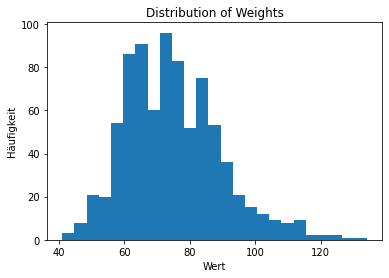

In [9]:
import matplotlib.pyplot as plt

weights=[]
for link in graph['links']:
    weights.append(link['weight'])

plt.hist(weights, bins=25)
plt.title("Distribution of Weights")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.show()

## Ausdünnung / Thresholding

Mehr thematische Struktur wird sichtbar, wenn wir nur Reden verbinden, die viele Worte gemeinsam haben. Das heißt, wir löschen die Kanten, deren Gewicht unter einem bestimmten Wert (threshold) liegt. Was hier der richtige Wert ist, ist immer wieder eine spannende Frage (A).

In [19]:
newlinks = []
for link in graph['links']:
    if link['weight'] > 100:
        newlinks.append(link)
graph['links'] = newlinks 
len(graph['links'])

46

## Netzwerkvisualisierung

Nun wollen wir uns dieses Netzwerk anschauen. Dazu benutzen wir den Interactive Visualiser ebenfalls aus dem Paket Network Tools bei Penelope. Diesem übergeben wir den Graphen. Außerdem können wir angeben, welches Attribut farblich kodiert sein soll und welcher Text sichtbar sein soll. 

Auch dieser Aufruf kann einige Zeit in Anspruch nehmen.

In [22]:
json = {'data':graph, 
        'nodecoloring':'party', 
        'nodelabel': 'text', 
        "darkmode": False,
        "edgevisibility": True,
        "particles": False
       }
result = requests.post('https://penelope.vub.be/network-components/visualiser', json=json)
result

<Response [200]>

Das Resultat speichern wir in einem HTML-File. 

In [23]:
with open (f"./redenet{Stichwort}.html", "w", encoding='utf-8') as f:
    f.write(result.json()['graph'])

---



# Fine Tuning und Erkundungen

### <font color='red'>Hier ist der Bereich, in dem ich ein Dinge ausprobiere.</font>

Das müsst ihr jetzt noch nicht unbedingt anschauen. Wahrscheinlich wird auch nicht alles funktionieren, da ich Bibliotheken lade (spacy), deren Installation etwas aufwendiger ist.


In [ ]:
import tqdm
import spacy
#nlp = spacy.load('de') #load spacy model

from collections import Counter
import collections

In [ ]:
def StatementGraphGenerator(inParams):

    stm_list = inParams['data']
    
    if inParams['language'] == 'en':
        nlp = spacy.load('en_core_web_sm') #load english spacy model
    elif inParams['language'] == 'de':
        nlp = spacy.load('de_core_news_sm') #load german spacy model
    elif inParams['language'] == 'fr':
        nlp = spacy.load('fr_core_news_sm') #load french spacy model
    elif inParams['language'] == 'es':
        nlp = spacy.load('es_core_news_sm') #load spanish spacy model
    elif inParams['language'] == 'pt':
        nlp = spacy.load('pt_core_news_sm') #load portuguese spacy model
    elif inParams['language'] == 'it':
        nlp = spacy.load('it_core_news_sm') #load italian spacy model
    elif inParams['language'] == 'nl':
        nlp = spacy.load('nl_core_news_sm') #load dutch spacy model
    elif inParams['language'] == 'el':
        nlp = spacy.load('el_core_news_sm') #load greek spacy model
    elif inParams['language'] == 'nb':
        nlp = spacy.load('nb_core_news_sm') #load norwegian bokmal spacy model
    elif inParams['language'] == 'lt':
        nlp = spacy.load('lt_core_news_sm') #load lithuanian spacy model
    elif inParams['language'] == 'xx':
        nlp = spacy.load('xx_ent_wiki_sm') #load multi-language spacy model

    else:
        print('ERROR! Language not supported!')
        
    relevantPOS = inParams['pos']
    ignoreLEM = inParams['ignore']
    
    # 1.2.2 Note: requires spacy and language model to be loaded
    print('apply nlp pipeline')
    for value in tqdm.tqdm(stm_list):
        doc = nlp(value['text'])
        value.update({'doc' : doc})
    
    # 1.2.3
    # Data cleaning options
    print('filter words')
    #relevantPOS = ['NOUN','VERB','ADJ']
    #ignoreLEM = ['Herr','Kollege','Dame','Frau','Präsident']
    #ignoreLEM = []

    stm_list_nlp = []
    statements_lemma_list = []
    #statements_pos_list = []
    for stm in tqdm.tqdm(stm_list):
        lemmas = []
        pos = []
        for token in stm['doc']:
            if token.is_punct is not True and token.is_stop is not True and token.pos_ in relevantPOS and token.lemma_ not in ignoreLEM:
                lemmas.append(token.lemma_)
                pos.append(token.pos_)
        stm.update({'lemmata' : lemmas})    
        statements_lemma_list.append(lemmas)
        #statements_pos_list.append(pos)

    # 1.2.4
    print('count and order lemmata')
    flattened = [val for lemmas in statements_lemma_list for val in lemmas]
    lemma_frequency_list = collections.Counter(flattened).most_common()
    all_lemmata_list = [ i[0] for i in lemma_frequency_list ]
    all_lemmata_count = [ i[1] for i in lemma_frequency_list ]

    # remove single items
    # 1.2.5
    print('remove singles')
    all_freq_lemmata_list = [ all_lemmata_list[i] for i,v in enumerate(all_lemmata_list) if (all_lemmata_count[i] > 1) ]
    all_freq_lemmata_count = [ all_lemmata_count[i] for i,v in enumerate(all_lemmata_count) if (all_lemmata_count[i] > 1) ]
        
    all_lemmata_list = all_freq_lemmata_list
    all_lemmata_count = all_freq_lemmata_count 

    # Construct word browsable dict for later use in semantic relatedness computation
    wordscounts_dict = {}
    for lx,lem in enumerate(all_lemmata_list):
        wordscounts_dict.update({ lem : all_lemmata_count[lx] })
 
    # From this file
    stmnet_dict = {
        'nodes' : [],
        'links' : []
        }    
 

    for ix,stm in enumerate(stm_list):
        if len(stm['lemmata']) > 0:
            node_dict = {
                'id' : ix+1
            }
            for ele in stm:
                if ele != 'lemmata' and ele != 'doc':
                    node_dict.update({ele : stm[ele]})
            
            mfic = [ lem for lem in all_lemmata_list if (lem in stm['lemmata'] )]
            freqI = collections.Counter(stm['lemmata']).most_common()
            #lemmataI = [ i[0] for i in freqI ]
            if len(mfic)>0:
                #node_dict.update({'mfic' : mfic[0]})
                node_dict.update({'mfic' : freqI[0]})
            else:
                node_dict.update({'mfic' : ' '})
    
            stmnet_dict['nodes'].append(node_dict)
    
    
    #stmnet_dict['graph']['edges'] = []
    for nodeI in tqdm.tqdm(stmnet_dict['nodes']):
        stmI = stm_list[ nodeI['id']-1 ]['lemmata']
        for nodeJ in stmnet_dict['nodes']:     
            if nodeI['id'] < nodeJ['id']:
                stmJ = stm_list[ nodeJ['id']-1 ]['lemmata']
                overlap = [ lem for lem in set(stmI) if (lem in set(stmJ))]  # set overlap
                weight = len(overlap) #/ (len(stmI)+len(stmJ))
                if (len(overlap) > 0):
                    edge_dict = {
                        'source' : nodeI['id'],
                        'target' : nodeJ['id'],
                        'weight' : weight
                        }
                    stmnet_dict['links'].append(edge_dict)
    
    return stmnet_dict

In [ ]:
Stichwort = "Darfur"
Reden = []
Reden = suche(Stichwort)
len(Reden)

In [ ]:

input_list = []
for rede in Reden:
            input_dict = {
                'name'  : rede["name"],
                'party' : rede["party"],
                'text'  : rede["text"]
            }
            input_list.append(input_dict) 

json = {
          "data": input_list,
          "language": "de",
          "pos": ["PROPN"],
          "ignore": [Stichwort,'Herr','Frau','Präsident','Präsidentin', 'Damen', 'Herren']
}

graph = StatementGraphGenerator(json)

In [ ]:
print(len(graph['links']),
len(graph['nodes']))

weights=[]
for link in graph['links']:
    weights.append(link['weight'])

plt.hist(weights, bins=25)
plt.title("Distribution of Weights")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.show()

In [ ]:
newlinks = []
for link in graph['links']:
    if link['weight'] > 3:
        newlinks.append(link)
graph['links'] = newlinks 
print(len(graph['links']))

In [ ]:


json = {'data':graph, 
        'nodecoloring':'party', 
        'nodelabel': 'mfic', 
        "darkmode": False,
        "edgevisibility": True,
        "particles": False
       }
result = requests.post('https://penelope.vub.be/network-components/visualiser', json=json)

In [ ]:
with open (f"./redenet{Stichwort}.html", "w") as f:
    f.write(result.json()['graph'])

In [ ]:
import re
re.compile('[A-Z]{3}')

In [ ]:
print(graph['nodes'][0])

In [ ]:
#for node in graph['nodes']:
#    print(node['mfic'])

In [ ]:


text ='Sehr geehrte Frau Präsidentin! Werte Kolleginnen und Kollegen! Klimaschutz ist eine große Herausforderung. Er ist wichtig, für manche Inseln im Pazifik ist er eine Überlebensfrage. Aber auch bei uns in Deutschland sind die Auswirkungen des Klimawandels bereits spürbar. Die Entwicklung von Innovationen im Bereich Klimaschutz ist eine Riesenchance für die Wirtschaft. Wir müssen am Ball bleiben. Wir müssen den Wandel gestalten. Wir dürfen ihn nicht verschlafen. Ich war gestern im Umweltministerium, wo der Deutsche Innovationspreis für Klima und Umwelt an mutige Unternehmer verliehen wurde. Auch mir machte diese Veranstaltung Mut, weil ich gesehen habe, mit welcher Kraft und mit welcher Überzeugung die Unternehmer bei der Sache sind. Es wurden tolle Projekte vorgestellt. Zum Beispiel kann Papier aus Gras hergestellt werden, um die Ressource Holz als wertvollen CO 2 -Speicher zu schonen. Ein weiteres Projekt war eine energiesparende Maschine zur Stoffherstellung, die gleichzeitig spinnt und strickt. Sie sehen: Es gibt eine Menge Innovationen durch mutige mittelständische Unternehmer, wodurch Arbeitsplätze geschaffen und auch erhalten werden können. Im ausverhandelten Koalitionsvertrag haben wir ganz klar festgehalten, dass wir uns zu unseren nationalen, europäischen und internationalen Klimazielen bekennen, und zwar in allen Sektoren. Dafür habe ich mich als Klimapolitikerin persönlich eingesetzt. Damit zeigen wir: Wir nehmen unsere klimapolitische Verantwortung wahr, in Deutschland und in der Welt. Für uns ist aber auch wichtig, wie wir dieses Ziel erreichen. Das wollen wir durch Anreize statt Zwang und durch Technologieoffenheit bewerkstelligen. Wir wollen auch sicherstellen, dass unsere Wirtschaft als Basis unseres Wohlstands international wettbewerbsfähig bleibt. Außerdem soll die Energieversorgungssicherheit weiterhin gewährleistet werden. Es liegt eine Studie der deutschen Industrie vor, die sich damit befasst hat, wie wir das langfristige Klimaziel bezogen auf 2050 erreichen wollen. Die Studie besagt: Das wird schwierig, aber es kann funktionieren. Und auch die Wirtschaft sagt: Die Wirtschaft kann Wandel. Sie hat es bei der Industrialisierung bewiesen. Jetzt nimmt sie die Herausforderungen der Digitalisierung an, Stichwort Industrie 4.0. Die Wirtschaft kann auch Klimaschutz, wenn die Politik verlässliche Rahmenbedingungen schafft und Anreize zum Beispiel für effiziente Umwelttechnologien setzt. Und genau das machen wir, meine Damen und Herren. Wenn Sie, die Antragsteller, deren Vorlagen wir heute beraten, den ausgehandelten Koalitionsvertrag aufmerksam lesen, dann werden Sie feststellen, dass viele Ihrer Punkte bereits enthalten sind, zum Beispiel die Forderung nach einer konsequenten Energieeffizienzpolitik. Es gibt bereits den Nationalen Aktionsplan Energieeffizienz, den wir weiterentwickeln werden. Außerdem wollen wir eine ambitionierte, sektorübergreifende Energieeffizienzstrategie unter dem Leitprinzip „Efficiency first“ installieren. Wir haben uns das ehrgeizige Ziel gesetzt, eine Halbierung des Energieverbrauchs bis 2050 zu schaffen. Im Koalitionsvertrag ist vorgesehen, bis 2030 einen Anteil an erneuerbaren Energien von 65 Prozent zu erreichen. Ebenso haben wir verankert – ich muss ganz ehrlich sagen: endlich –, die energetische Gebäudesanierung steuerlich zu fördern. In vielen Reden an diesem Rednerpult habe ich gefordert, dass wir dieses Klimaschutzinstrument nutzen. Meine Damen und Herren, ich setze darauf, dass nun auch die Grünen in den Bundesländern für dieses Instrument werben; denn in den Jamaika-Sondierungen war die Einführung dieses Instruments Konsens. Damit bin ich beim Thema: Wie sollen diese Instrumente ausgestaltet sein? Wie soll dieses Steuerungsinstrument ausgestaltet sein? Wir setzen auf Anreize statt auf Zwang. Unser Vorschlag sieht ein Wahlrecht des Antragstellers vor: Zuschussförderung oder Reduzierung des zu versteuernden Einkommens. Damit erreichen wir einen möglichst großen Personenkreis. Daneben wollen wir das CO 2 -Gebäudesanierungsprogramm fortführen und damit den Austausch alter, ineffizienter Heizungen fördern. Ferner wollen wir eine Kommission einsetzen, die auf Basis und in Vernetzung mit dem laufenden Prozess zur Umsetzung des Klimaschutzplans bis Ende des Jahres Maßnahmen vorschlagen soll, wie die Lücke zur Erreichung des Klimaziels 2020 so schnell wie möglich reduziert werden kann und im Energiesektor das 2030-Ziel erreicht werden kann. Dazu zählt auch die schrittweise Reduzierung und Beendigung der Kohleverstromung. Das Abschlussdatum für die Kohleverstromung soll ebenfalls durch diese Kommission festgelegt werden. Hört! Hört! Meine Damen und Herren, das geht sogar über das hinaus, was am Ende der Jamaika-Sondierungen ausverhandelt war. In den Jamaika-Verhandlungen lag der Fokus – Herr Dr. Köhler hat es bereits erwähnt – auf dem überhasteten, schnellen Stilllegen, auf der Reduzierung der Kapazität der Kohleverstromung um 7 Gigawatt vor 2020, und zwar ohne Rücksicht auf die Arbeitsplätze. Auch wir wollen die schrittweise Reduzierung der Kohleverstromung; aber wir wollen dabei die Energieversorgung weiterhin sicherstellen. Wir wollen, dass Energie für Verbraucher und Wirtschaft bezahlbar bleibt. Das ist ganz wichtig. Ich habe das Gefühl, das wird von den Grünen öfter ausgeblendet. Außerdem wollen wir nicht, dass es in den betroffenen Regionen zu Strukturbrüchen kommt. Sie sehen: Wir reden nicht nur, sondern wir handeln auch, aber durchdacht und mit Weitsicht. Zur Globalen Allianz für den Kohleausstieg, die in einem Antrag erwähnt wird: Gefordert wird, dass Deutschland dieser Allianz beitritt. Ich habe mir die Mühe gemacht, mir den Energiemix der teilnehmenden Staaten anzusehen. Man muss sich da ehrlich machen. Wie ist das in Frankreich? Dort stammen nur 3 bis 4 Prozent der Stromproduktion aus der Kohle, und Frankreich will von dem Ziel abrücken, den Strom aus Kernenergie bis 2025 auf 50 Prozent zu reduzieren. Kanada investiert mehr als 25 Milliarden in Atomreaktoren, damit sie für weitere 25 bis 30 Jahre laufen. Großbritannien will aus der Kohleverstromung aussteigen, gleichzeitig aber den Anteil des Stroms aus Kernenergie deutlich steigern. Wir wollen beides: Wir wollen die Kohleverstromung reduzieren und den Ausstieg aus der Kernenergienutzung weiter gestalten. Keiner behauptet, dass das leicht ist. Dennoch gehen wir diesen Weg voller Überzeugung für unsere Kinder, für unsere Enkel und für die Menschen, die darauf setzen, dass die Politik die Weichen richtig stellt und durch Innovationen im Umweltbereich Arbeitsplätze erhalten und geschaffen werden. Vielen Dank. Vielen Dank, Dr. Weisgerber. – Nächste Rednerin: Bundesministerin Dr. Barbara Hendricks für die Bundesregierung.'
text2 = 'Vielen Dank. – Herr Präsident! Liebe Kolleginnen und Kollegen! Seit dem Jahr 2007 leistet die United Nations Hybrid Operation in Darfur, UNAMID, einen wichtigen Beitrag, um den langjährigen Konflikt im Sudan um die Region Darfur zu lösen. Seit dem Jahr 2008 beteiligt sich Deutschland mit den von der Mandatsobergrenze her erlaubten bis zu 50 Soldatinnen und Soldaten an dieser Mission. Aktuell sind sieben deutsche Soldatinnen und Soldaten bei UNAMID im Einsatz. Sie dienen im Hauptquartier in al-Fashir und unterstützen die Missionsführung von UNAMID bei der Umsetzung ihrer anspruchsvollen Aufgaben. UNAMID ist wie UNMISS – darüber diskutieren wir anschließend – ein Mandat, das sich in unser politisches, sicherheits- und entwicklungspolitisches sowie humanitäres Gesamtengagement in der Region und im Rahmen der Vereinten Nationen einfügt. Die gesamte Sudan-Sahel-Region steht großen Herausforderungen gegenüber. Es seien die Stichworte genannt: Terrorismus, organisierte Kriminalität, Flucht und Migration. Das nachhaltige Engagement der internationalen Gemeinschaft zur regionalen Stabilisierung ist und bleibt daher von entscheidender Bedeutung. Auftrag von UNAMID ist die Überwachung des Waffenstillstandsabkommens von Darfur aus dem Jahr 2006, die Sicherung eines humanitären Zugangs zur Region, die Unterstützung und Überwachung der Vermittlungsbemühungen in Konflikten zwischen den Bevölkerungsgruppen sowie der Schutz und die Unterstützung der Zivilbevölkerung. Deutschland, liebe Kolleginnen und Kollegen, ist derzeit die einzige europäische Nation bei UNAMID. Unsere fortgesetzte Beteiligung ist deshalb auch ein wichtiges Zeichen an die Vereinten Nationen, an die Afrikanische Union, dass wir die Friedensanstrengungen der internationalen Gemeinschaft in Darfur weiterhin unterstützen. Sie ist zudem ein wichtiges Zeichen und wesentlicher Rückhalt für die Bemühungen der sudanesischen Akteure, selbst zur Verbesserung der Sicherheitslage und politischen Konfliktlösung in Darfur zu kommen. Liebe Kolleginnen und Kollegen, angesichts positiver Entwicklungen im Sudan hat der Sicherheitsrat der Vereinten Nationen im Juni dieses Jahres eine Neuausrichtung von UNAMID beschlossen. Diese sieht innerhalb der nächsten zwei Jahre eine Reduzierung des militärischen Anteils um circa 45 Prozent der Kräfte, vor allem in der Fläche, und des polizeilichen Anteils um circa 26 Prozent der Kräfte vor. Damit einher geht eine Akzentverschiebung zu mehr zivil geprägtem Peacekeeping und Peacebuilding. Der Schwerpunkt von UNAMID wird aber weiterhin in einem Beitrag zum Schutz der Zivilbevölkerung sowie in der Unterstützung der Vermittlungsbemühungen zwischen den Konfliktparteien liegen. Eine erste Bewertung dieser Anpassung durch die Vereinten Nationen Anfang kommenden Jahres werden wir selbstverständlich mit großem Interesse aufnehmen. Sie muss insbesondere die Realitäten am Boden berücksichtigen. Liebe Kolleginnen und Kollegen, trotz dieser positiven Signale bleibt die Lage in Darfur insgesamt angespannt und instabil. Insbesondere die humanitäre Situation ist mit allein 2,1 Millionen Binnenvertriebenen vor allem in humanitärer Hinsicht katastrophal. UNAMID wird deshalb auch in Zukunft eine Schlüsselrolle in Darfur spielen. Die Mission dient als stabilisierendes Element zur Verbesserung der Sicherheitslage, zur Sicherung des humanitären Zugangs nach Darfur, zur Überwachung und Verbesserung der Menschenrechtslage sowie zur Begleitung der politischen Friedensbemühungen. Daher ist es wichtig, dass auch Deutschland sein Engagement in dieser wichtigen VN-Mission unverändert fortführt. Es ist, wie gesagt, eine kleine Mission; 50 Soldatinnen und Soldaten ist die Obergrenze. Wir sind mit Stabspersonal dort. Es ist eine wichtige Mission: humanitär und politisch. Es ist wichtig, dass wir unsere Solidarität nicht verweigern. Liebe Kolleginnen und Kollegen, bei allem, was noch zu tun ist, bei allen fortdauernden Herausforderungen und Katastrophen möchte ich daran erinnern, dass der damalige UN-Generalsekretär Kofi Annan zurzeit des Bürgerkrieges Darfur als den furchtbarsten Platz auf der Erde bezeichnete. Nun will ich nicht vorwegnehmen, was hier in dieser Debatte noch gesagt wird, aber wir haben die eine oder andere Debatte hinter uns. Manche mögen sagen: Der Westen ist schuld an der Katastrophe. Andere möchten vielleicht fragen: Was geht uns das an? Liebe Kolleginnen und Kollegen, beides ist und wäre falsch. Es ist Teil unserer Aufgabe als Bundesrepublik Deutschland, als Europäer, unseren Beitrag zu leisten, dass sich der Fortschritt weiter Bahn bricht und die humanitäre Katastrophe in Darfur, die humanitäre Katastrophe im Sudan ein Ende findet. Dazu sind wir verpflichtet. Dafür bitte ich namens der Bundesregierung um Ihre Unterstützung. Vielen Dank. Nächste Rednerin ist Dr. Bärbel Kofler für die Fraktion der SPD.'
doc = nlp(text2)
for sent in doc.sents:
    for token in sent:
        print(token.lemma_,token.pos_)
